In [1]:
import pandas as pd
import scanpy as sc
import squidpy as sq
import numpy as np 
from anndata import AnnData
import networkx as nx

In [38]:

from sklearn.metrics import pairwise_distances
# import spatialHeterogeneity as sh
import re
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, Normalize
from scipy.stats import wilcoxon
import matplotlib.patches as mpatches
import seaborn as sns

In [55]:
def scatter_cell_plot(adata:AnnData, coordx:str, coordy:str, color_type:str, size=1.0, title=None, color_mapper=None):
    fig, axs = plt.subplots(1, 1, figsize=(15,15))
    cell_type_color_mapper = sns.color_palette("Set2", len(adata.obs[color_type].unique()))
    if color_mapper is None: 
        color_mapper = dict()
        for index, color in enumerate(cell_type_color_mapper):
    #         print(color)
            color_mapper[sorted(list(adata.obs[color_type].unique()))[index]] = color
    
    legend_patches = list()
    for key, value in color_mapper.items():
        tmp_patch = mpatches.Patch(color=value, label=key)
        legend_patches.append(tmp_patch)

    for index, row in adata.obs.iterrows():
        axs.scatter(row[coordx],row[coordy],
                    color=color_mapper[row[color_type]],
                    linewidth=1.0)
#     axs.imshow(rotated_image)
    if title is None:
        title = color_type
        
    axs.legend(handles=legend_patches,
               bbox_to_anchor=(1.0, 1.0),
               loc=2, title=title, prop={'size': 8})
    return axs, fig

In [3]:
from tqdm import tqdm

In [4]:
smi_anndata = sc.read_h5ad('../1123_anndata_SMI_better.h5ad')

In [5]:
smi_anndata.to_df()

,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,ACTA2,ACTG2,...,WNT5B,WNT7A,WNT7B,WNT9A,XBP1,XCL1,XCL2,YBX3,YES1,ZFP36
cell_ID,,,,,,,,,,,,,,,,,,,,,
c_1_1_2,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
c_1_1_3,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.377914,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.377914,0.000000,1.377914
c_1_1_5,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,3.433491,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
c_1_1_6,0.0,0.0,0.000000,0.0,0.0,6.648983,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
c_1_1_7,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,8.548692,0.000000,0.0,0.0,0.0,0.0,8.548692,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c_7_25_614,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
c_7_25_616,0.0,0.0,0.000000,0.0,0.0,0.000000,2.755828,0.0,0.000000,0.0,...,0.0,2.755828,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,2.755828
c_7_25_617,0.0,0.0,7.348876,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [6]:
smi_anndata.obs

,sdimx,sdimy,ROI,fov,Area,AspectRatio,Width,Height,leiden_clus,IFcolor,...,slide_ID_numeric,Run_Tissue_name,Panel,Diversity,totalcounts,Slide_name,Run_name,tissue,healthyProfile,cancerProfile
cell_ID,,,,,,,,,,,,,,,,,,,,,
c_1_1_2,0.45504,-57.89942,c1_1,1,2407,2.00,76,38,2,#007000FF,...,1,B18,980p,52,80,S1,Run1069,B18,KC_Other,KC_Diff
c_1_1_3,0.47286,-57.90248,c1_1,1,5598,1.71,123,72,3,#008C00FF,...,1,B18,980p,143,304,S1,Run1069,B18,KC_Other,KC_Diff
c_1_1_5,0.50796,-57.89996,c1_1,1,2292,1.93,85,44,2,#007400FF,...,1,B18,980p,71,122,S1,Run1069,B18,KC_Other,KC_Basal
c_1_1_6,0.52812,-57.89852,c1_1,1,1966,2.66,77,29,2,#008100FF,...,1,B18,980p,38,63,S1,Run1069,B18,KC_Other,KC_Diff
c_1_1_7,0.54288,-57.89924,c1_1,1,1941,2.47,89,36,2,#00A000FF,...,1,B18,980p,25,49,S1,Run1069,B18,KC_Diff,KC_Diff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c_7_25_614,1.22276,-23.07822,c7_25,25,6891,1.03,109,106,2,#4F1A06FF,...,7,66487-1A,980p,37,59,S3,Run1069,66487-1A,KC_Diff,KC_Diff
c_7_25_616,0.77060,-23.07534,c7_25,25,6399,1.07,92,86,5,#1E0C2DFF,...,7,66487-1A,980p,98,152,S3,Run1069,66487-1A,Endothelial,KC_Cyc
c_7_25_617,0.80624,-23.07606,c7_25,25,10215,1.40,132,94,2,#1F0A2DFF,...,7,66487-1A,980p,41,57,S3,Run1069,66487-1A,KC_Diff,KC_Diff


In [7]:
color2dict = {'Endothelial' : "#FFA500", 
  'Fibroblast' : "#458B00", 
  'Melanocyte' : "#1874CD",
  'Pilosebaceous' : "#8B4513",
  'B.PDC' : "#6959CD",
  'Myeloid' : "#EEEE00",
  'NK.T' : "#9ACD32",
  'KC_Basal' : "#CD96CD",
  'KC_Cyc' : "#FFB5C5",
  'KC_Other' : "#CD5555",
  'KC_Diff' : "#FF6EB4",
  'NotDet' : "#7F7F7F"}

In [8]:
b18_subset = smi_anndata[smi_anndata.obs['Run_Tissue_name']=='B18']

In [10]:
b18_subset

AnnData object with n_obs × n_vars = 31699 × 960
    obs: 'sdimx', 'sdimy', 'ROI', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'leiden_clus', 'IFcolor', 'dualfiles', 'ISH.concentration', 'slide_ID_numeric', 'Run_Tissue_name', 'Panel', 'Diversity', 'totalcounts', 'Slide_name', 'Run_name', 'tissue', 'healthyProfile', 'cancerProfile'
    uns: 'cancerProfile_colors'
    obsm: 'spatial', 'umap'

In [11]:
# b18_subset.obs.fov.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [14]:
b18_subset.var_names_make_unique()

In [17]:
b18_subset_sub = b18_subset[b18_subset.obs.fov.isin([ 13, 14, 15])]

In [19]:
b18_subset_sub.obs

,sdimx,sdimy,ROI,fov,Area,AspectRatio,Width,Height,leiden_clus,IFcolor,...,slide_ID_numeric,Run_Tissue_name,Panel,Diversity,totalcounts,Slide_name,Run_name,tissue,healthyProfile,cancerProfile
cell_ID,,,,,,,,,,,,,,,,,,,,,
c_1_13_1,2.02924,-47.89668,c1_13,13,2245,1.19,63,53,6,#020000FF,...,1,B18,980p,113,190,S1,Run1069,B18,Melanocyte,Endothelial
c_1_13_2,2.03842,-47.89434,c1_13,13,990,1.59,43,27,4,#200500FF,...,1,B18,980p,26,33,S1,Run1069,B18,Fibroblast,Endothelial
c_1_13_3,2.11402,-47.89596,c1_13,13,2679,1.93,87,45,11,#040000FF,...,1,B18,980p,62,122,S1,Run1069,B18,Fibroblast,Fibroblast
c_1_13_4,2.13868,-47.89812,c1_13,13,4444,1.28,88,69,6,#040200FF,...,1,B18,980p,154,265,S1,Run1069,B18,Fibroblast,Fibroblast
c_1_13_5,2.16082,-47.89632,c1_13,13,2715,1.88,90,48,11,#040100FF,...,1,B18,980p,34,69,S1,Run1069,B18,Melanocyte,Melanocyte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c_1_15_2865,2.07510,-47.23248,c1_15,15,890,2.14,47,22,11,#000000FF,...,1,B18,980p,19,33,S1,Run1069,B18,NK.T,NotDet
c_1_15_2866,2.12784,-47.23086,c1_15,15,1397,1.21,47,39,11,#000000FF,...,1,B18,980p,100,171,S1,Run1069,B18,NK.T,NK.T
c_1_15_2867,2.49054,-47.23194,c1_15,15,1114,2.30,62,27,9,#00FF00FF,...,1,B18,980p,57,115,S1,Run1069,B18,KC_Other,KC_Diff


In [20]:
b18_subset_sub.to_df()

,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,ACTA2,ACTG2,...,WNT5B,WNT7A,WNT7B,WNT9A,XBP1,XCL1,XCL2,YBX3,YES1,ZFP36
cell_ID,,,,,,,,,,,,,,,,,,,,,
c_1_13_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
c_1_13_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.693512,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
c_1_13_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,3.433491,0.000000,0.0,0.0,0.0,0.0,0.0
c_1_13_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
c_1_13_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c_1_15_2865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,38.080536,0.0,0.0,0.0,0.0,0.0
c_1_15_2866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.449625,0.0,...,0.0,0.0,4.899251,4.899251,4.899251,0.0,0.0,0.0,0.0,0.0
c_1_15_2867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [31]:
b18_subset_sub.uns['spatial'] = b18_subset_sub.obs[['sdimx','sdimy']]

(<AxesSubplot: >, <Figure size 1500x1500 with 1 Axes>)

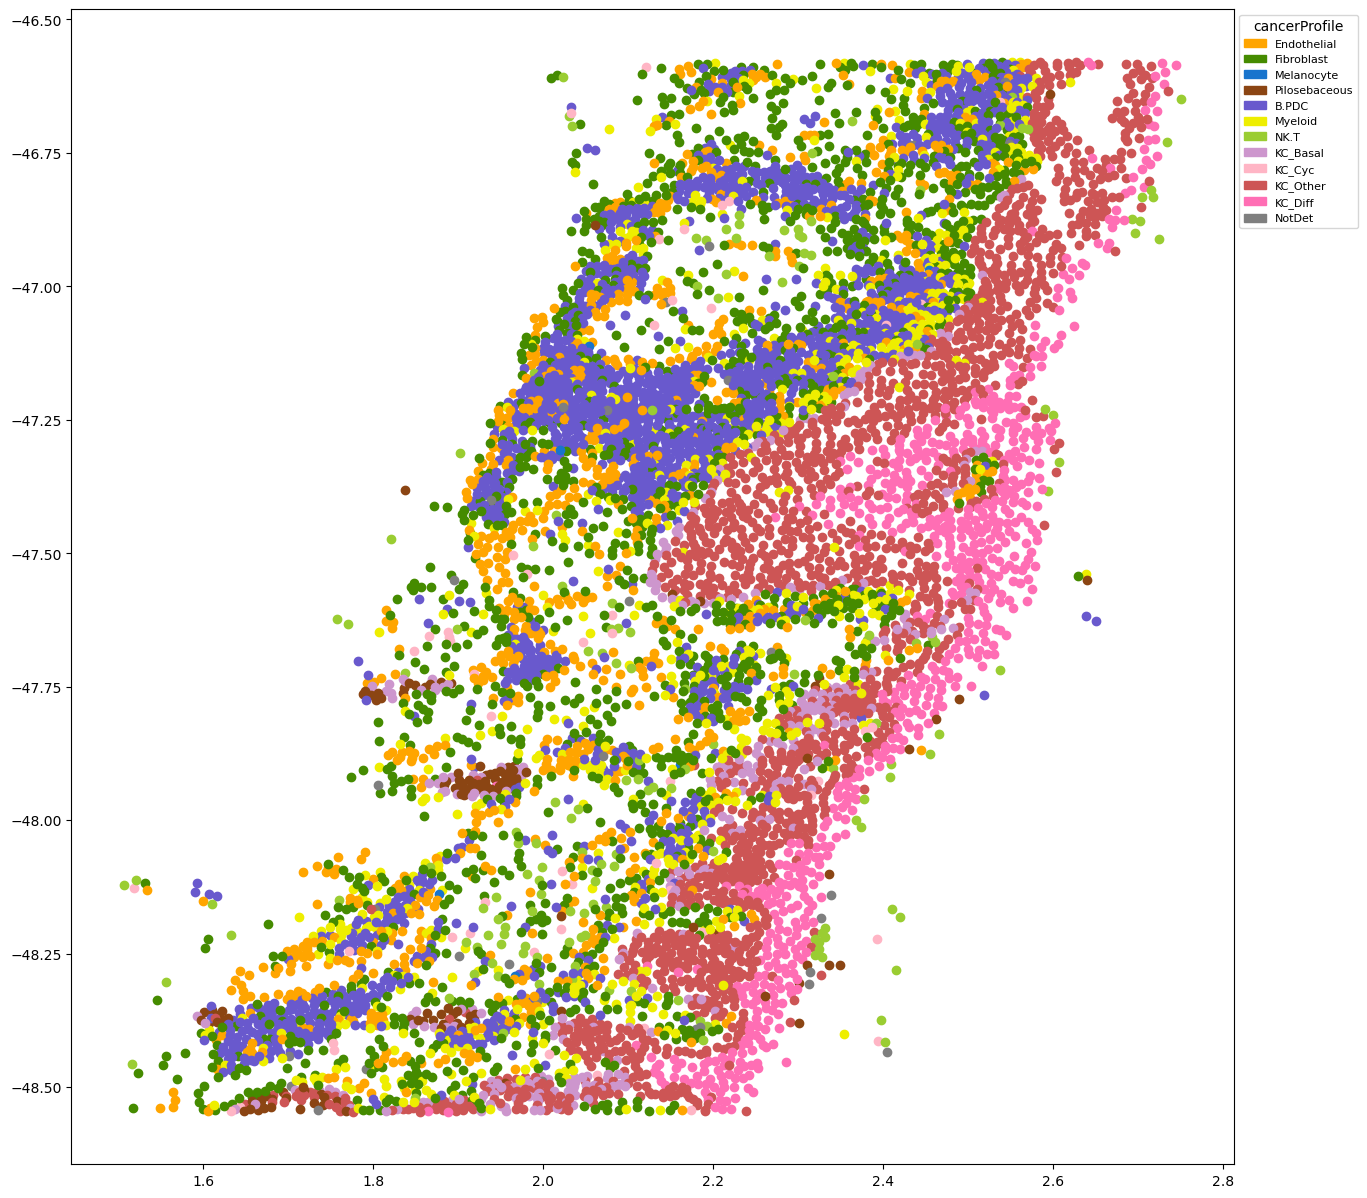

In [56]:
# fig2 = plt.figure(figsize = (20,20))
# ax3 = fig2.add_subplot(111)
# ax3.invert_yaxis()
# sc.pl.spatial(b18_subset_sub, color='cancerProfile', spot_size=0.02)#, ax=ax3)
# 
scatter_cell_plot(b18_subset_sub, 'sdimx','sdimy', 'cancerProfile', color_mapper=color2dict)

In [52]:
mel_subset = smi_anndata[smi_anndata.obs['Run_Tissue_name']=='48974-2B', color2dict]


In [53]:
mel_subset.to_df()

,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,ACTA2,ACTG2,...,WNT5B,WNT7A,WNT7B,WNT9A,XBP1,XCL1,XCL2,YBX3,YES1,ZFP36
cell_ID,,,,,,,,,,,,,,,,,,,,,
c_6_1_1,0.0,0.000000,0.000000,0.0,1.296860,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.890581,1.296860,0.000000,0.00000,0.0,3.890581,0.0,2.593721
c_6_1_2,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,9.413166,0.00000,0.0,4.706583,0.0,0.000000
c_6_1_3,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,2.327144,0.00000,0.0,2.327144,0.0,0.000000
c_6_1_4,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,1.193407
c_6_1_5,0.0,0.000000,0.785902,0.0,0.785902,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.785902,0.000000,0.000000,0.00000,0.0,1.571805,0.0,0.785902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c_6_17_634,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000
c_6_17_635,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000
c_6_17_637,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20.685724,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000


In [57]:
mel_subset.to_df()[['CD44','AXL', 'MKI67']]

,CD44,AXL,MKI67
cell_ID,,,
c_6_1_1,0.000000,0.000000,0.0
c_6_1_2,0.000000,0.000000,0.0
c_6_1_3,0.000000,2.327144,0.0
c_6_1_4,0.000000,1.193407,0.0
c_6_1_5,0.785902,0.000000,0.0
...,...,...,...
c_6_17_634,0.000000,0.000000,0.0
c_6_17_635,0.000000,0.000000,0.0
c_6_17_637,0.000000,0.000000,0.0


In [59]:
mel_subset2 = mel_subset[(mel_subset[:,'CD44'].X>0).flatten(), :]
mel_subset2 = mel_subset2[(mel_subset2[:,'AXL'].X>0).flatten(), :]
mel_subset2 = mel_subset2[(mel_subset2[:,'MKI67'].X>0).flatten(), :]
mel_subset2

View of AnnData object with n_obs × n_vars = 451 × 960
    obs: 'sdimx', 'sdimy', 'ROI', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'leiden_clus', 'IFcolor', 'dualfiles', 'ISH.concentration', 'slide_ID_numeric', 'Run_Tissue_name', 'Panel', 'Diversity', 'totalcounts', 'Slide_name', 'Run_name', 'tissue', 'healthyProfile', 'cancerProfile'
    obsm: 'spatial', 'umap'

In [60]:
mel_subset2.to_df()

,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,ACTA2,ACTG2,...,WNT5B,WNT7A,WNT7B,WNT9A,XBP1,XCL1,XCL2,YBX3,YES1,ZFP36
cell_ID,,,,,,,,,,,,,,,,,,,,,
c_6_1_8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.612406,1.224813,0.000000,0.000000,0.000000,0.000000,1.837219,0.000000,0.000000
c_6_1_72,0.000000,0.000000,0.468029,0.000000,0.000000,0.000000,3.276203,0.000000,0.000000,0.000000,...,0.468029,0.000000,0.000000,0.468029,0.468029,0.936058,0.000000,1.872116,0.000000,0.000000
c_6_1_110,0.214593,0.214593,0.000000,0.214593,0.000000,0.000000,2.360525,0.429186,0.214593,0.000000,...,0.429186,0.643780,1.287559,1.931339,0.214593,0.858373,0.000000,4.077271,0.000000,0.214593
c_6_1_137,0.345901,0.000000,0.000000,0.345901,0.345901,0.000000,2.421306,0.691802,0.345901,0.345901,...,0.345901,0.345901,0.000000,0.691802,0.345901,1.037702,0.691802,4.150810,0.000000,0.000000
c_6_1_152,0.000000,0.000000,0.761611,0.000000,0.000000,0.761611,2.284832,0.000000,0.000000,0.000000,...,0.761611,0.000000,0.000000,2.284832,0.761611,2.284832,0.000000,2.284832,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c_6_17_386,0.000000,0.000000,0.583407,0.000000,0.000000,0.000000,1.750220,0.000000,0.000000,0.000000,...,0.000000,0.583407,1.166813,0.000000,0.000000,0.583407,0.583407,1.166813,0.000000,0.583407
c_6_17_399,0.000000,0.300492,0.000000,0.300492,0.000000,0.000000,1.201968,0.000000,0.000000,0.901476,...,0.000000,0.000000,0.000000,1.502460,0.000000,0.600984,0.600984,1.201968,0.000000,0.000000
c_6_17_404,0.168092,0.168092,0.168092,0.336185,0.000000,0.168092,2.017107,0.000000,0.168092,0.336185,...,0.168092,0.168092,0.840461,2.017107,0.000000,1.008554,0.168092,1.008554,0.168092,0.672369


In [62]:
mel_subset2.to_df()[['CD44','AXL', 'MKI67']]

,CD44,AXL,MKI67
cell_ID,,,
c_6_1_8,1.837219,0.612406,1.224813
c_6_1_72,0.468029,0.936058,0.468029
c_6_1_110,0.214593,0.429186,0.429186
c_6_1_137,0.691802,0.691802,0.345901
c_6_1_152,1.523221,0.761611,1.523221
...,...,...,...
c_6_17_386,2.333626,1.166813,0.583407
c_6_17_399,0.300492,0.300492,0.300492
c_6_17_404,0.840461,0.504277,1.344738


In [61]:
mel_subset2.obs

,sdimx,sdimy,ROI,fov,Area,AspectRatio,Width,Height,leiden_clus,IFcolor,...,slide_ID_numeric,Run_Tissue_name,Panel,Diversity,totalcounts,Slide_name,Run_name,tissue,healthyProfile,cancerProfile
cell_ID,,,,,,,,,,,,,,,,,,,,,
c_6_1_8,12.64444,-7.93198,c6_1,1,6530,1.29,123,95,2,#E49533FF,...,6,48974-2B,980p,243,684,S3,Run1069,48974-2B,KC_Diff,KC_Diff
c_6_1_72,12.30424,-7.96834,c6_1,1,4408,0.54,69,128,5,#FFAB73FF,...,6,48974-2B,980p,354,895,S3,Run1069,48974-2B,B.PDC,KC_Cyc
c_6_1_110,12.41008,-7.98130,c6_1,1,5900,1.33,104,78,5,#C8A81AFF,...,6,48974-2B,980p,585,1952,S3,Run1069,48974-2B,Endothelial,KC_Cyc
c_6_1_137,12.67594,-7.99120,c6_1,1,3875,1.50,99,66,5,#B3B700FF,...,6,48974-2B,980p,480,1211,S3,Run1069,48974-2B,Endothelial,KC_Cyc
c_6_1_152,12.55786,-7.99750,c6_1,1,3357,1.61,95,59,5,#825306FF,...,6,48974-2B,980p,295,550,S3,Run1069,48974-2B,Endothelial,KC_Cyc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c_6_17_386,18.02842,-1.17670,c6_17,17,3968,1.18,85,72,5,#578A13FF,...,6,48974-2B,980p,341,718,S3,Run1069,48974-2B,Fibroblast,Fibroblast
c_6_17_399,17.87452,-0.69916,c6_17,17,3045,0.97,71,73,5,#902C46FF,...,6,48974-2B,980p,586,1394,S3,Run1069,48974-2B,Endothelial,KC_Cyc
c_6_17_404,17.75734,-0.72400,c6_17,17,6771,1.83,146,80,5,#5D2800FF,...,6,48974-2B,980p,726,2492,S3,Run1069,48974-2B,Endothelial,KC_Cyc


In [66]:
mel_subset2.obs.ROI.unique()

['c6_1', 'c6_2', 'c6_3', 'c6_8', 'c6_9', ..., 'c6_13', 'c6_14', 'c6_15', 'c6_16', 'c6_17']
Length: 12
Categories (12, object): ['c6_1', 'c6_2', 'c6_3', 'c6_8', ..., 'c6_14', 'c6_15', 'c6_16', 'c6_17']

In [ ]:
mel_subset2 

(<AxesSubplot: >, <Figure size 1500x1500 with 1 Axes>)

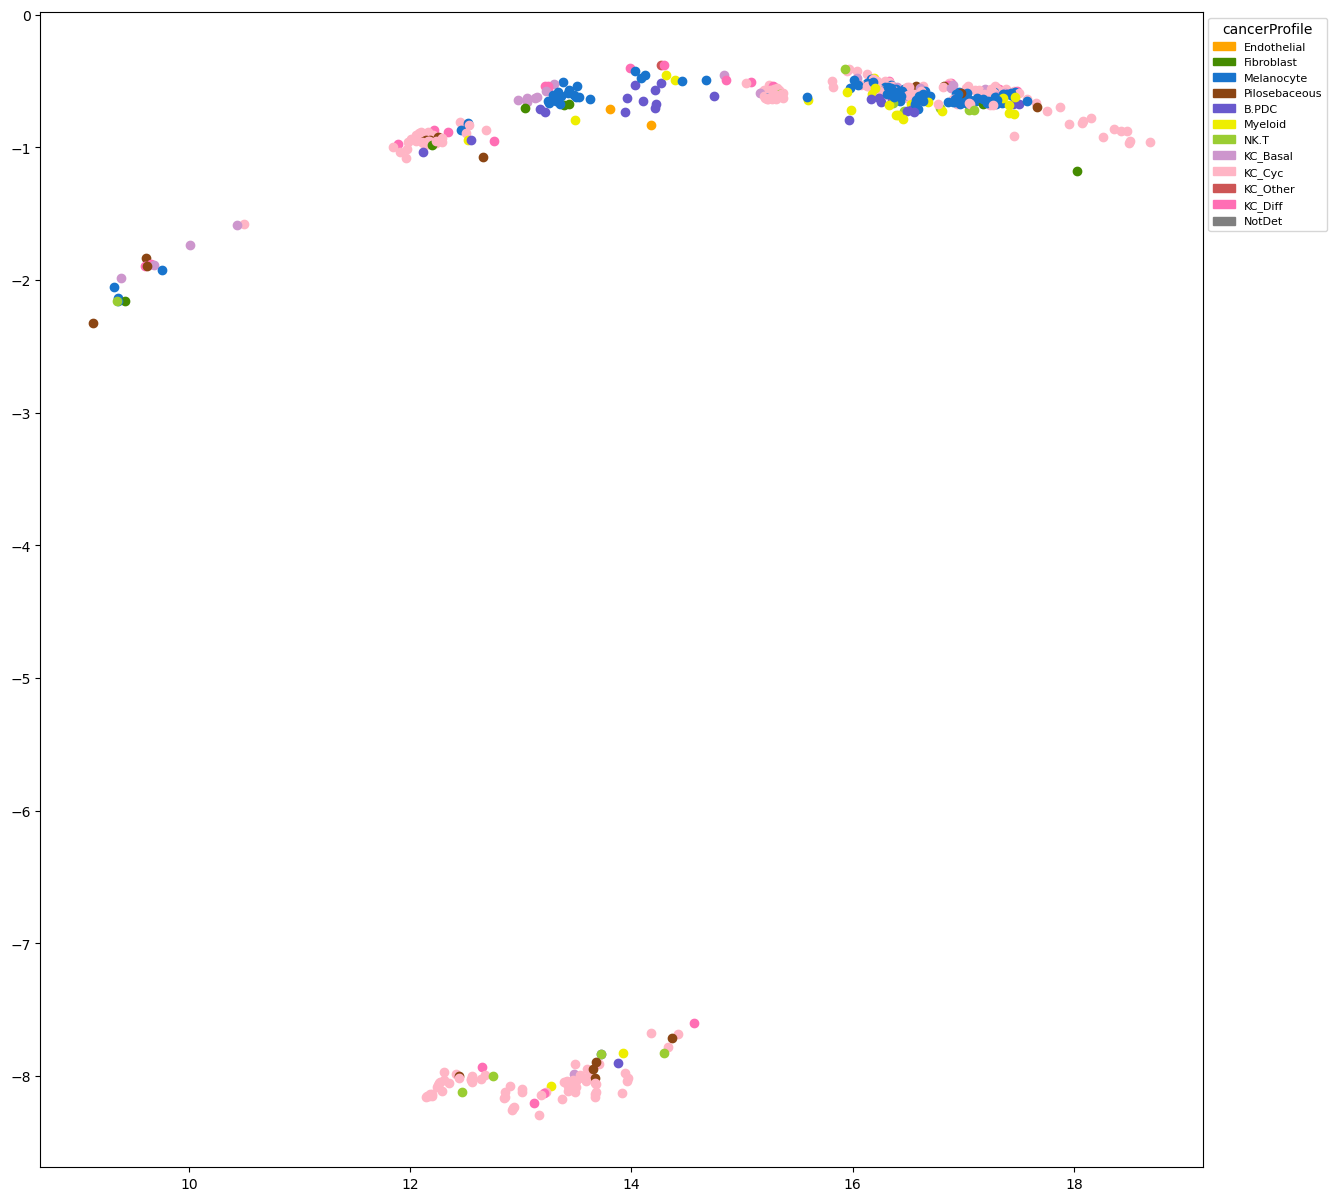

In [70]:
scatter_cell_plot(mel_subset2, 'sdimx','sdimy', 'cancerProfile', size=0.1, color_mapper=color2dict)

In [64]:
# scatter_cell_plot(mel_subset, 'sdimx','sdimy', 'cancerProfile', color_mapper=color2dict)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x2b96afa60> (for post_execute):


KeyboardInterrupt: 

In [ ]:
mel_subset2 = mel_subset[[mel_subset]]

In [45]:
# test = sq.datasets.imc()

In [46]:
# test

In [27]:
test.to_df()

,1021522Tm169Di EGFR,1031747Er167Di ECadhe,112475Gd156Di Estroge,117792Dy163Di GATA3,1261726In113Di Histone,1441101Er168Di Ki67,174864Nd148Di SMA,1921755Sm149Di Vimenti,198883Yb176Di cleaved,201487Eu151Di cerbB,...,71790Dy162Di CD45,77877Nd146Di CD68,8001752Sm152Di CD3epsi,92964Er166Di Carboni,971099Nd144Di Cytoker,98922Yb174Di Cytoker,phospho Histone,phospho S6,phospho mTOR,Area
0,1.061895,8.085332,0.337812,0.321856,22.676172,0.068810,0.364338,0.094569,1.669934,4.350186,...,0.160391,0.192944,0.033263,1.481392,0.126192,0.081556,0.564968,1.468315,1.761658,55.0
1,1.010395,8.308472,0.320835,0.224368,14.195655,0.021648,0.553934,0.036734,1.457793,3.211087,...,0.160315,0.094140,0.156084,0.979076,0.122359,0.139130,0.305365,1.024873,1.616977,93.0
2,1.077522,5.274055,0.922280,0.628528,33.087868,0.046367,1.708991,0.000000,1.232840,0.745345,...,0.004864,0.130166,0.000000,2.007145,0.514660,0.000000,0.465301,2.192775,2.067328,15.0
3,1.576723,11.119562,0.576232,0.312170,23.579065,0.195567,6.628324,0.000000,1.552365,3.856008,...,0.181149,0.320298,0.094284,1.313890,0.403974,0.000000,0.140070,0.265316,2.366359,18.0
4,0.702806,8.522112,0.428847,0.197394,20.523558,0.199734,3.194194,0.933255,1.943893,3.115766,...,0.311178,0.499227,0.270265,1.405548,0.488878,0.042310,0.241761,0.615953,1.980837,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4707,0.625143,5.911421,0.601428,0.320534,13.650654,0.057998,0.111695,0.000000,1.593383,3.332439,...,0.008074,0.079715,0.062850,1.399778,0.095043,0.000000,0.149433,2.722149,2.060011,34.0
4708,1.021963,3.117383,0.272802,0.158449,14.322868,0.180664,0.210680,0.063195,1.713520,5.943739,...,0.060717,0.214405,0.204475,1.775037,0.087685,0.000000,0.155141,0.435964,2.776099,19.0
4709,0.620875,3.037405,0.241602,0.394792,15.694256,0.131815,0.493719,0.000000,1.652438,3.803927,...,0.139092,0.051660,0.049747,1.206817,0.099784,0.069096,0.209134,0.386426,1.760313,28.0
4710,0.766836,4.233937,0.065262,0.097693,19.958614,1.629305,0.122124,0.279252,1.358616,2.651239,...,0.226655,0.144621,0.117215,1.266033,0.100777,0.037203,0.418111,0.626131,1.748487,24.0


In [ ]:
# test.obs

In [30]:
test.obsm['spatial']

array([[  1.70909091,  15.32727273],
       [  3.84946237,  42.07526882],
       [  0.86666667,  50.33333333],
       ...,
       [730.14285714, 636.96428571],
       [730.375     , 658.04166667],
       [729.87628866, 679.63917526]])

In [33]:
sq.pl.spatial_scatter(test, color="cell type")

KeyError: "Spatial key 'spatial' not found in `adata.uns`."